# Shopping Habits Cluster Analysis
In this workbook, we will attempt to cluster panelists based on their grocery shopping habits and demographics.

## Setting Up Environment 

Importing Libraries

In [1]:
!pip -q install kneed
!pip -q install yellowbrick==1.3

     |████████████████████████████████| 271 kB 5.0 MB/s 


In [2]:
import re
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime
import numpy as np
import math
from scipy.stats import pointbiserialr
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import silhouette_visualizer
from kneed import KneeLocator
from decimal import Decimal

Read in datasets

In [3]:
raw_trnsact_data = pd.read_csv('DACC_Hackathon_TransactionData.csv')
raw_cat_data = pd.read_csv('DACC_Hackathon_Categories_Information_V2.csv')
raw_demog_data = pd.read_excel('DACC_Hackathon_Panelists_Demogs.xlsx')

In [4]:
raw_trnsact_data.head()

Panel ID        Date          Category  Pack Size  Volume  Spend
0  101011101.0  2018-04-29             SUGAR        2.0     2.0    5.9
1  101011101.0  2018-04-29      COCONUT MILK        3.0     0.6    9.6
2  101011101.0  2018-05-06              CAKE        1.0     0.2    5.0
3  101011101.0  2018-05-06              CAKE        1.0     0.5    5.0
4  101011101.0  2018-05-06  SEASONING POWDER        2.0     0.1    4.2

In [5]:
raw_cat_data.head()

Category  Calories/100g  Price per Volume
0       Beer             43             14.16
1    Belacan            563             43.11
2  Bird Nest             46             90.33
3   Biscuits            416             15.72
4    Bouilon             16             28.93

In [6]:
raw_demog_data.head()

ID          BMI  ...            #HH         Income
0  Panel 101011101        Obese  ...  1-3 Member HH  <RM2000 (Low)
1  Panel 101016101      Healthy  ...  1-3 Member HH  <RM2000 (Low)
2  Panel 101019101        Obese  ...  4-5 Member HH  <RM2000 (Low)
3  Panel 101024101  Over Weight  ...  1-3 Member HH  <RM2000 (Low)
4  Panel 105009103  Over Weight  ...  1-3 Member HH  <RM2000 (Low)

[5 rows x 8 columns]

## Data Pre-processing

### Categories Data

In [7]:
raw_cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Category          62 non-null     object 
 1   Calories/100g     62 non-null     int64  
 2   Price per Volume  62 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ KB


In [8]:
raw_cat_data['Category'] = raw_cat_data['Category'].str.upper()

In [9]:
cat_df = raw_cat_data.copy()

### Transaction Data

In [10]:
# raw_trnsact_data = raw_trnsact_data.drop(['Unnamed: 0'], axis=1)
raw_trnsact_data['Panel ID'] = raw_trnsact_data['Panel ID'].astype(int).astype(str)
raw_trnsact_data.rename(columns={'Panel ID':'ID'}, inplace=True)
raw_trnsact_data['Date'] = pd.to_datetime(raw_trnsact_data['Date'], format='%Y-%m-%d')

In [11]:
# check for food captured in transaction data but not in categories data
raw_trnsact_data[~raw_trnsact_data['Category'].isin(list(raw_cat_data['Category']))]

Empty DataFrame
Columns: [ID, Date, Category, Pack Size, Volume, Spend]
Index: []

In [12]:
raw_trnsact_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1389941 entries, 0 to 1389940
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   ID         1389941 non-null  object        
 1   Date       1389941 non-null  datetime64[ns]
 2   Category   1389941 non-null  object        
 3   Pack Size  1389941 non-null  float64       
 4   Volume     1389941 non-null  float64       
 5   Spend      1389941 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 63.6+ MB


In [13]:
raw_trnsact_data.head()

ID       Date          Category  Pack Size  Volume  Spend
0  101011101 2018-04-29             SUGAR        2.0     2.0    5.9
1  101011101 2018-04-29      COCONUT MILK        3.0     0.6    9.6
2  101011101 2018-05-06              CAKE        1.0     0.2    5.0
3  101011101 2018-05-06              CAKE        1.0     0.5    5.0
4  101011101 2018-05-06  SEASONING POWDER        2.0     0.1    4.2

In [14]:
raw_trnsact_data.describe()

Pack Size        Volume         Spend
count  1.389941e+06  1.389941e+06  1.389941e+06
mean   1.505324e+00  3.244771e+00  9.754271e+00
std    1.996702e+00  7.561964e+00  1.582565e+01
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    1.000000e+00  3.000000e-01  3.600000e+00
50%    1.000000e+00  8.000000e-01  5.800000e+00
75%    2.000000e+00  2.000000e+00  1.090000e+01
max    3.000000e+02  6.000000e+02  2.250000e+03

In [15]:
print('First recorded purchase: {0}'.format(raw_trnsact_data['Date'].min()))
print('Last recorded purchase: {0}'.format(raw_trnsact_data['Date'].max()))
print('Time between last and first purchase: {0}'.format(raw_trnsact_data['Date'].max() - raw_trnsact_data['Date'].min()))

First recorded purchase: 2018-04-29 00:00:00
Last recorded purchase: 2021-04-25 00:00:00
Time between last and first purchase: 1092 days 00:00:00


In [16]:
print('Number of unique panelists: {0}'.format(raw_trnsact_data['ID'].nunique()))

Number of unique panelists: 3917


In [17]:
trnsact_df = raw_trnsact_data.copy()

### Demographics Data

In [18]:
raw_demog_data['Income']

0                  <RM2000 (Low)
1                  <RM2000 (Low)
2                  <RM2000 (Low)
3                  <RM2000 (Low)
4                  <RM2000 (Low)
                  ...           
3913    RM5000-RM7999 (Mid High)
3914     RM3000-RM4999 (Mid Low)
3915    RM5000-RM7999 (Mid High)
3916    RM5000-RM7999 (Mid High)
3917     RM3000-RM4999 (Mid Low)
Name: Income, Length: 3918, dtype: object

In [19]:
# remove "Panel " in front of every PanelID number in the ID column
raw_demog_data['ID'] = raw_demog_data['ID'].str.replace('Panel ', '')

# remove numbers in the Income column
raw_demog_data['Income'] = raw_demog_data['Income'].str.extract(r"\((.*)\)")

In [20]:
raw_demog_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3918 entries, 0 to 3917
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3918 non-null   object
 1   BMI        3918 non-null   object
 2   Ethnicity  3918 non-null   object
 3   Strata     3918 non-null   object
 4   Location   3918 non-null   object
 5   Lifestage  3918 non-null   object
 6   #HH        3918 non-null   object
 7   Income     3918 non-null   object
dtypes: object(8)
memory usage: 245.0+ KB


In [21]:
raw_demog_data.head()

ID          BMI  ...            #HH Income
0  101011101        Obese  ...  1-3 Member HH    Low
1  101016101      Healthy  ...  1-3 Member HH    Low
2  101019101        Obese  ...  4-5 Member HH    Low
3  101024101  Over Weight  ...  1-3 Member HH    Low
4  105009103  Over Weight  ...  1-3 Member HH    Low

[5 rows x 8 columns]

In [22]:
print('Number of unique panelists: {0}'.format(raw_demog_data['ID'].nunique()))

Number of unique panelists: 3918


In [23]:
demog_df = raw_demog_data.copy()

## Exploratory Data Analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


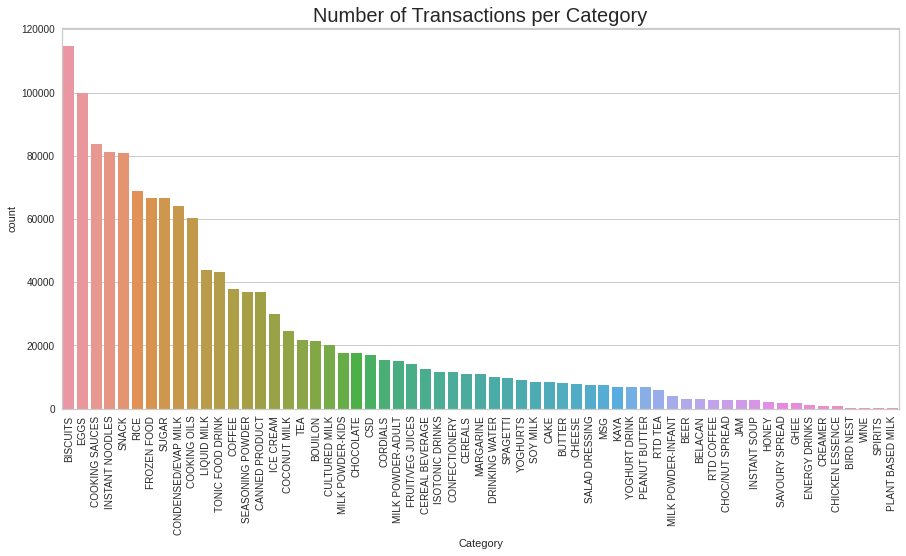

In [24]:
plt.figure(figsize=(15,7));
ax = sns.countplot(trnsact_df['Category'], 
                   order = trnsact_df['Category'].value_counts().index);
ax.set_title("Number of Transactions per Category", fontsize=20);
plt.xticks(rotation=90);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


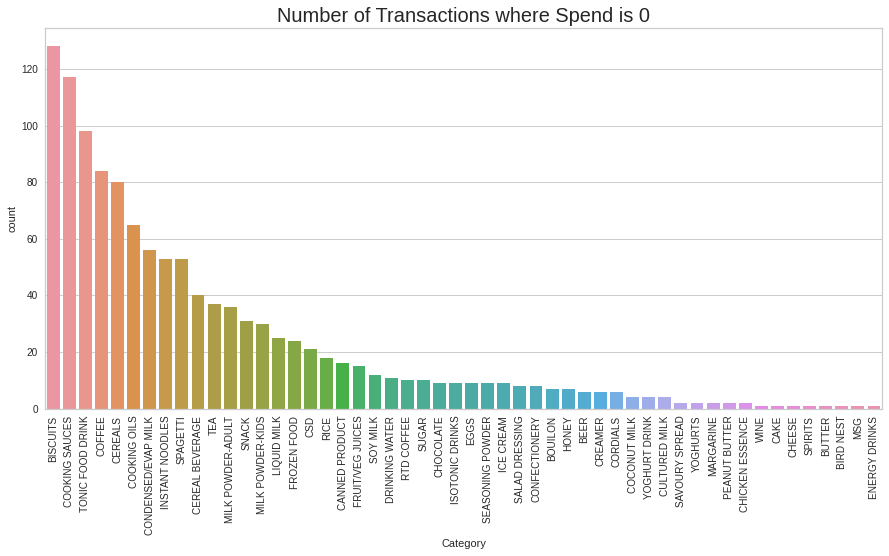

In [25]:
plt.figure(figsize=(15,7));
ax = sns.countplot(trnsact_df[trnsact_df['Spend']==0]['Category'], 
                   order = trnsact_df[trnsact_df['Spend']==0]['Category'].value_counts().index);
ax.set_title("Number of Transactions where Spend is 0", fontsize=20);
plt.xticks(rotation=90);

The plot above reveals that there are **some transactions where the panelist did not spend any money**. These transactions could possibly be erroneous data or items received by the panelist in 'buy-one-get-one-free' sales. Therefore, **we will remove these transactions** as the panelist did not intentionally purchase them.

In [26]:
trnsact_df = trnsact_df[trnsact_df['Spend']>0]

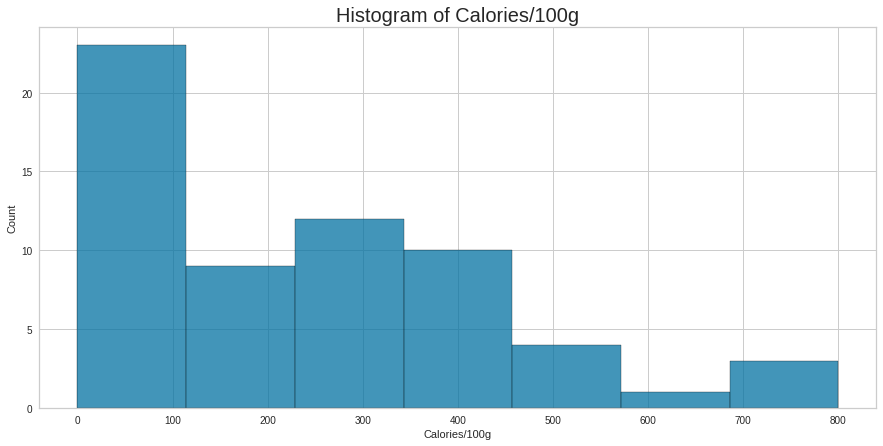

In [27]:
plt.figure(figsize=(15,7));
ax = sns.histplot(cat_df['Calories/100g']);
ax.set_title("Histogram of Calories/100g", fontsize=20);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


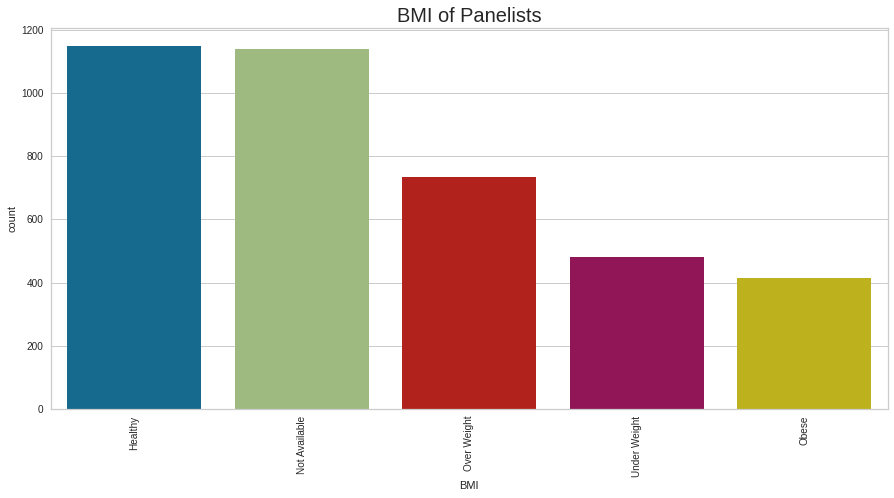

In [28]:
plt.figure(figsize=(15,7));
ax = sns.countplot(demog_df['BMI'], 
                   order = demog_df['BMI'].value_counts().index);
ax.set_title("BMI of Panelists", fontsize=20);
plt.xticks(rotation=90);

## Feature Engineering

### 6 main food groups
1. Snacks
2. Cooking Essentials
3. Carbohydrates
4. Beverages
5. Alcohol
6. Dairy/ Eggs

In [29]:
cat_df['Food Group'] = ['Alcohol', 'Cooking Essentials', 'Beverages', 'Snacks', 'Cooking Essentials', 'Cooking Essentials', 'Snacks', 'Cooking Essentials', 'Beverages', 
                       'Carbohydrates', 'Dairy/ Eggs', 'Cooking Essentials', 'Cooking Essentials', 'Snacks', 'Dairy/ Eggs', 'Beverages', 'Cooking Essentials', 
                       'Snacks', 'Cooking Essentials', 'Cooking Essentials', 'Alcohol', 'Dairy/ Eggs', 'Beverages', 'Beverages', 'Beverages', 'Dairy/ Eggs', 
                       'Beverages', 'Cooking Essentials', 'Cooking Essentials', 'Beverages', 'Cooking Essentials', 'Cooking Essentials', 'Snacks', 'Carbohydrates',
                       'Cooking Essentials', 'Beverages', 'Cooking Essentials', 'Cooking Essentials', 'Beverages', 'Cooking Essentials', 'Beverages', 'Beverages',
                       'Beverages', 'Cooking Essentials', 'Cooking Essentials', 'Beverages', 'Carbohydrates', 'Beverages', 'Beverages', 'Cooking Essentials', 
                       'Cooking Essentials', 'Cooking Essentials', 'Snacks', 'Beverages', 'Alcohol', 'Cooking Essentials','Carbohydrates',
                       'Beverages', 'Beverages', 'Alcohol', 'Beverages', 'Dairy/ Eggs']



### High or Low Calorie

According to this article released by the US Food & Drug Administration, foods that have more than 400 calories per 100g are considered high calorie foods. (https://www.accessdata.fda.gov/scripts/interactivenutritionfactslabel/calories.cfm)

In [30]:
cat_df['CalorieLevel'] = ["High" if x>400 else "Low" for x in cat_df['Calories/100g']]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


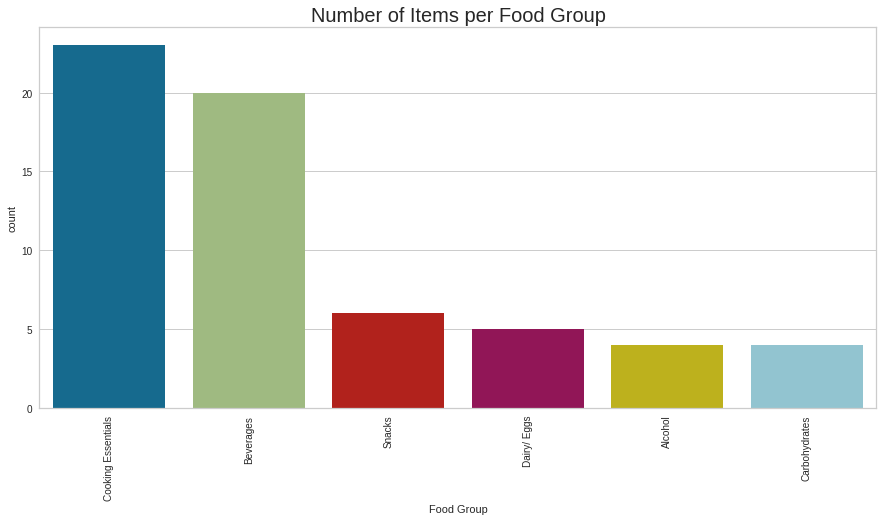

In [31]:
plt.figure(figsize=(15,7));
ax = sns.countplot(cat_df['Food Group'], 
                   order = cat_df['Food Group'].value_counts().index);
ax.set_title("Number of Items per Food Group", fontsize=20);
plt.xticks(rotation=90);

## Percentage of Spending by ID

In [32]:
# join transaction and category data
joined_df = pd.merge(trnsact_df, cat_df, on='Category', how='left')
joined_df

ID       Date  ...          Food Group  CalorieLevel
0        101011101 2018-04-29  ...  Cooking Essentials          High
1        101011101 2018-04-29  ...         Dairy/ Eggs           Low
2        101011101 2018-05-06  ...              Snacks           Low
3        101011101 2018-05-06  ...              Snacks           Low
4        101011101 2018-05-06  ...  Cooking Essentials           Low
...            ...        ...  ...                 ...           ...
1388743  802315301 2021-04-25  ...         Dairy/ Eggs           Low
1388744  802315301 2021-04-25  ...  Cooking Essentials           Low
1388745  802315301 2021-04-25  ...  Cooking Essentials           Low
1388746  802315301 2021-04-25  ...  Cooking Essentials           Low
1388747  802315301 2021-04-25  ...           Beverages           Low

[1388748 rows x 10 columns]

In [33]:
# get a df of total spending by each panelist
total_spending_by_ID = joined_df.groupby(['ID']).agg(TotalSpend = pd.NamedAgg('Spend', aggfunc='sum'))

# get a df of total spending on high calorie foods by each panelist
highcal_spending_by_ID = joined_df[joined_df['CalorieLevel']=="High"].groupby(['ID']).agg(HighCalSpend = pd.NamedAgg('Spend', aggfunc='sum'))

In [34]:
joined_df = pd.merge(joined_df, total_spending_by_ID, on='ID', how='left')

# get a df of total spending on each food group by each panelist
pctgofspending_df = joined_df.groupby(['ID', 'TotalSpend', 'Food Group']).agg(PctgSpend = pd.NamedAgg('Spend', aggfunc='sum'))
pctgofspending_df.reset_index(inplace=True)

# get a df of percentage of spending on each food group by each panelist
pctgofspending_df['PctgSpend'] = round(pctgofspending_df['PctgSpend']/pctgofspending_df['TotalSpend'] * 100, 1)
pctgofspending_df = pctgofspending_df.pivot(index='ID', columns='Food Group', values='PctgSpend')
pctgofspending_df.reset_index(inplace=True)
pctgofspending_df.columns.name = None
pctgofspending_df = pctgofspending_df.fillna(0)

In [35]:
# get a df of percentage of spending on high calorie foods by each panelist
highcal_spending_by_ID = pd.merge(total_spending_by_ID, highcal_spending_by_ID, on='ID', how='left').fillna(0)
highcal_spending_by_ID['PctgHighCal'] = round(highcal_spending_by_ID['HighCalSpend']/highcal_spending_by_ID['TotalSpend'] * 100, 1)

In [36]:
pctgofspending_df['HighCalorie'] = list(highcal_spending_by_ID['PctgHighCal'])

In [37]:
pctgofspending_df

ID  Alcohol  Beverages  ...  Dairy/ Eggs  Snacks  HighCalorie
0     101011101      1.5       12.2  ...          9.2     5.9         38.6
1     101016101      1.8       14.7  ...          2.2     4.9         39.6
2     101019101      0.9       31.6  ...         15.6     3.1         30.2
3     101024101      0.0       24.7  ...          9.0    10.4         23.9
4     105009103      0.8       35.0  ...          9.9     8.3         36.9
...         ...      ...        ...  ...          ...     ...          ...
3912  802312801      0.0       25.6  ...          0.0    43.0         43.0
3913  802313601      0.0       21.5  ...          0.0    19.1         38.0
3914  802314001      5.6       41.7  ...          6.6     6.1          9.5
3915  802315101      0.0       11.0  ...         19.3     2.9         25.8
3916  802315301      0.0       68.4  ...          5.7     3.5          8.4

[3917 rows x 8 columns]

In [38]:
# map percentages of spending back to the demographics data of each panelist
finaldf= pd.merge(pctgofspending_df, demog_df, on='ID', how='left')

In [39]:
finaldf.describe()
finaldf = finaldf[~finaldf['Income'].isna()]
finaldf = finaldf.drop(['ID'], axis=1)

In [40]:
X=finaldf.copy()
X

Alcohol  Beverages  ...            #HH    Income
0         1.5       12.2  ...  1-3 Member HH       Low
1         1.8       14.7  ...  1-3 Member HH       Low
2         0.9       31.6  ...  4-5 Member HH       Low
3         0.0       24.7  ...  1-3 Member HH       Low
4         0.8       35.0  ...  1-3 Member HH       Low
...       ...        ...  ...            ...       ...
3912      0.0       25.6  ...  4-5 Member HH  Mid High
3913      0.0       21.5  ...   6+ Member HH   Mid Low
3914      5.6       41.7  ...   6+ Member HH  Mid High
3915      0.0       11.0  ...  4-5 Member HH  Mid High
3916      0.0       68.4  ...  4-5 Member HH   Mid Low

[3916 rows x 14 columns]

In [41]:
#Encoding categorical data

X['BMI'] = X['BMI'].astype('category')
d1 = dict(zip(X['BMI'], X['BMI'].cat.codes))
X['BMI'] = X['BMI'].map(d1)
print("BMI Category Codes")
print(d1)

X['Ethnicity'] = X['Ethnicity'].astype('category')
d2 = dict(zip(X['Ethnicity'], X['Ethnicity'].cat.codes))
X['Ethnicity'] = X['Ethnicity'].map(d2)
print("Ethnicity Category Codes")
print(d2)

X['Strata'] = X['Strata'].astype('category')
d3 = dict(zip(X['Strata'], X['Strata'].cat.codes))
X['Strata'] = X['Strata'].map(d3)
print("Strata Category Codes")
print(d3)

X['Location'] = X['Location'].astype('category')
d4 = dict(zip(X['Location'], X['Location'].cat.codes))
X['Location'] = X['Location'].map(d4)
print("Location Category Codes")
print(d4)

X['Lifestage'] = X['Lifestage'].astype('category')
d5 = dict(zip(X['Lifestage'], X['Lifestage'].cat.codes))
print("Lifestage Category Codes")
X['Lifestage'] = X['Lifestage'].map(d5)
print(d5)

X['#HH'] = X['#HH'].astype('category')
d6 = dict(zip(X['#HH'], X['#HH'].cat.codes))
X['#HH'] = X['#HH'].map(d6)
print("#HH Category Codes")
print(d6)

X['Income'] = X['Income'].astype('category')
d7 = dict(zip(X['Income'], X['Income'].cat.codes))
X['Income'] = X['Income'].map(d7)
print("Income Category Codes")
print(d7)

BMI Category Codes
{'Obese': 2, 'Healthy': 0, 'Over Weight': 3, 'Under Weight': 4, 'Not Available': 1}
Ethnicity Category Codes
{'Malay': 1, 'Chinese': 0, 'Others': 2}
Strata Category Codes
{'Urban': 1, 'Rural': 0}
Location Category Codes
{'North': 2, 'South': 3, 'East Coast': 1, 'Central': 0}
Lifestage Category Codes
{'Empty Nesters': 0, 'Yankys/Matured Families': 4, 'Teens Aches': 2, 'Nesting Families': 1, 'Teens and Toddlers': 3}
#HH Category Codes
{'1-3 Member HH': 0, '4-5 Member HH': 1, '6+ Member HH': 2}
Income Category Codes
{'Low': 1, 'Low High': 2, 'Mid Low': 4, 'Mid High': 3, 'High': 0}


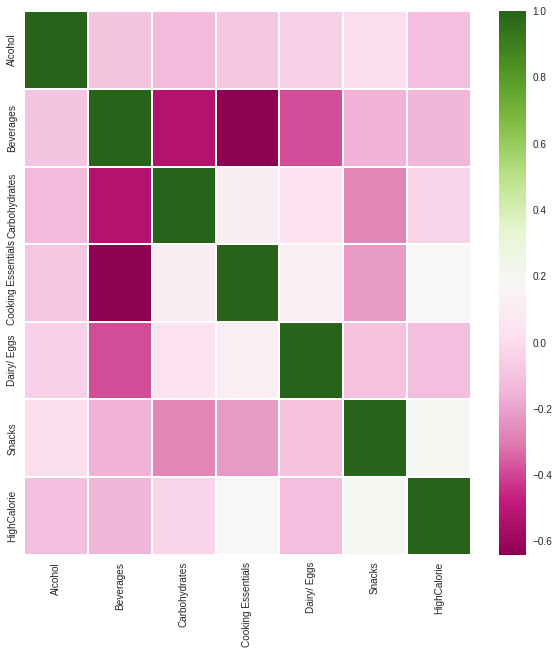

In [42]:
# Detecting collinearity between features
continuousvar= X.columns[0:7]
categoricalvar= X.columns[7:14]
continuous = X.loc[:,continuousvar]
categorical = X.loc[:,categoricalvar]

cont_corr=continuous.corr()
plt.figure(figsize=(10,10));
sns.heatmap(cont_corr, 
            xticklabels = cont_corr.columns, 
            yticklabels = cont_corr.columns, 
            cmap="PiYG", 
            linewidth = 1);

In [43]:
# Find Point biserial correlation
for cat_var in categoricalvar:
  for cont_var in  continuousvar:
    data_cat = X[cat_var].to_numpy()
    data_cont = X[cont_var].to_numpy()
    
    corr, p_val = pointbiserialr(x=data_cat, y=data_cont)
    if np.abs(corr) >= 0.7:
      print(f'Categorical variable: {cat_var}, Continuous variable: {cont_var}, correlation: {corr}')
#None correlated

In [44]:
# Find Pearson correlation
total_len = len(continuousvar)
for idx1 in range(total_len-1):
  for idx2 in range(idx1+1, total_len):
    cont_var1 = continuousvar[idx1]
    cont_var2 = continuousvar[idx2]
    data_cont1 = X[cont_var1].to_numpy()
    data_cont2 = X[cont_var2].to_numpy()
    corr, p_val = pearsonr(x=data_cont1, y=data_cont2)
    if np.abs(corr) >= 0.7:
      print(f' Continuous var 1: {cont_var1}, Continuous var 2: {cont_var2}, correlation: {corr}')
#None correlated

In [45]:
# Find Cramer's V correlation
total_len = len(categoricalvar)
for idx1 in range(total_len-1):
  for idx2 in range(idx1+1, total_len):
    cat_var1 = categoricalvar[idx1]
    cat_var2 = categoricalvar[idx2]    
    c_matrix = pd.crosstab(X[cat_var1], X[cat_var2])

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(c_matrix)[0]
    n = c_matrix.sum().sum()
    phi2 = chi2/n
    r,k = c_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    corr = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
    if corr >= 0.7:
      print(f'categorical variable 1 {cat_var1}, categorical variable 2: {cat_var2}, correlation: {corr}')
#None correlated

In [46]:
finaldf.head()

Alcohol  Beverages  ...            #HH  Income
0      1.5       12.2  ...  1-3 Member HH     Low
1      1.8       14.7  ...  1-3 Member HH     Low
2      0.9       31.6  ...  4-5 Member HH     Low
3      0.0       24.7  ...  1-3 Member HH     Low
4      0.8       35.0  ...  1-3 Member HH     Low

[5 rows x 14 columns]

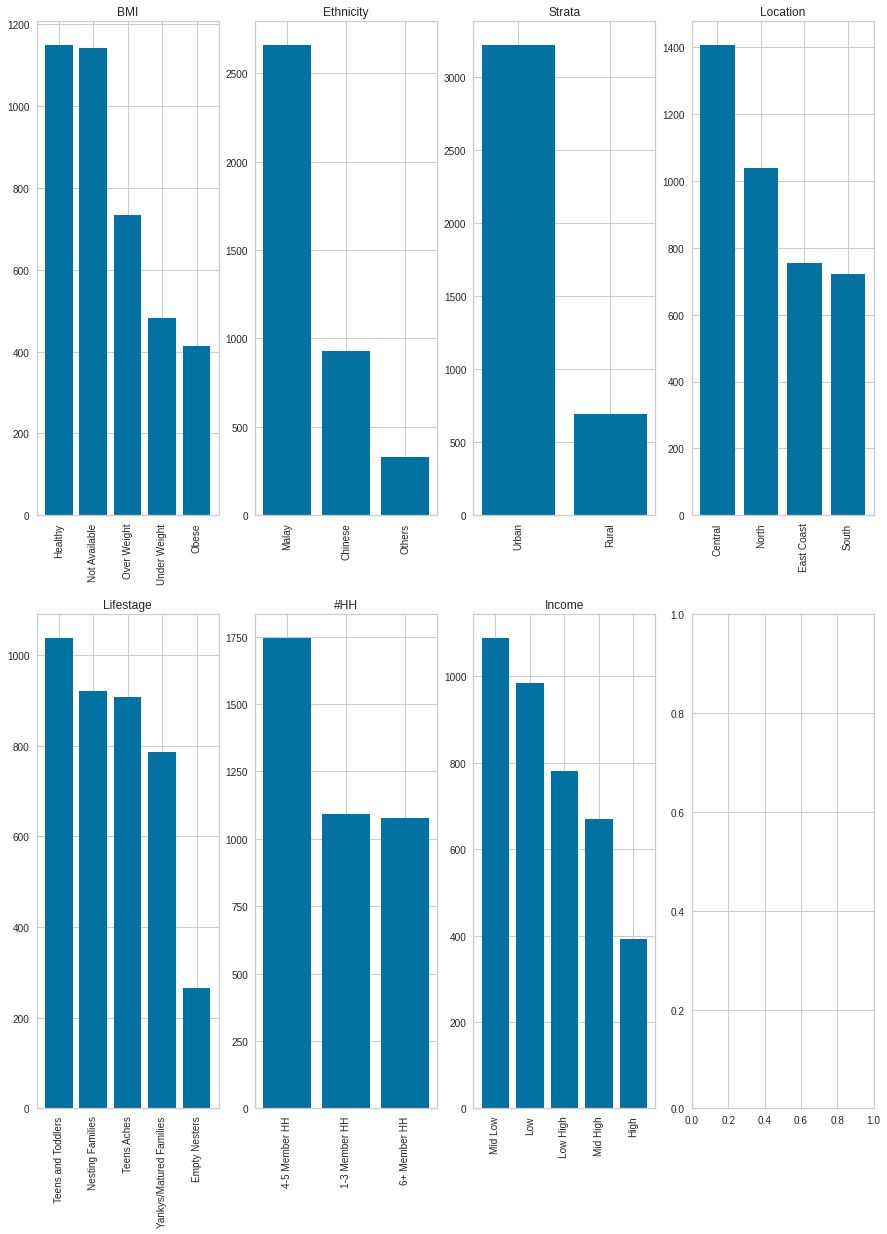

In [47]:
# plot to see distribution of categorical variables in demog_df
n_cols = 4
fig, axes = plt.subplots(nrows=int(np.ceil(demog_df.iloc[:,1:].shape[1]/n_cols)), 
                         ncols=n_cols, 
                         figsize=(15,20))

for i in range(demog_df.iloc[:,1:].shape[1]):
  var = demog_df.iloc[:,1:].columns[i]
  dist = demog_df[var].value_counts()
  labels = dist.index
  counts = dist.values
  ax = axes.flatten()[i]
  ax.bar(labels, counts)
  ax.tick_params(axis='x', labelrotation = 90)
  ax.title.set_text(var)


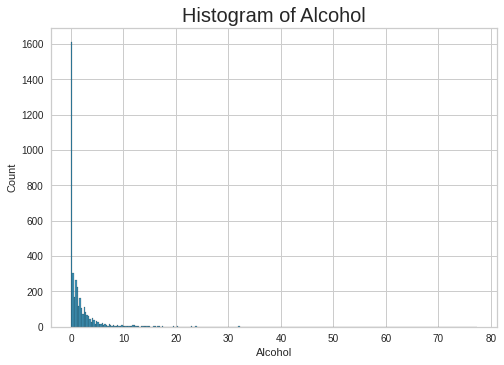

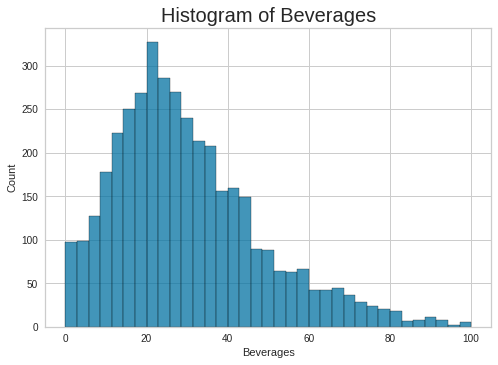

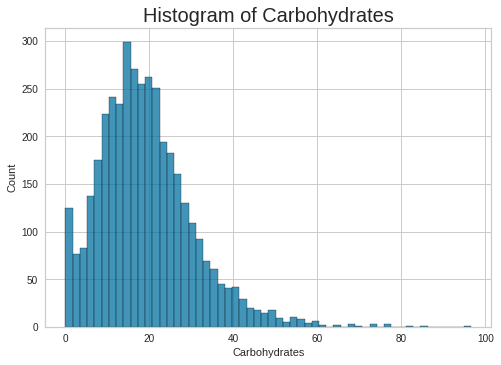

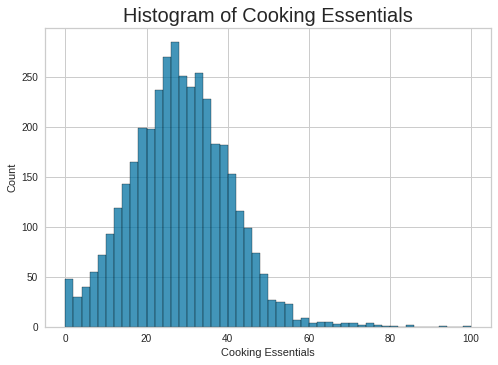

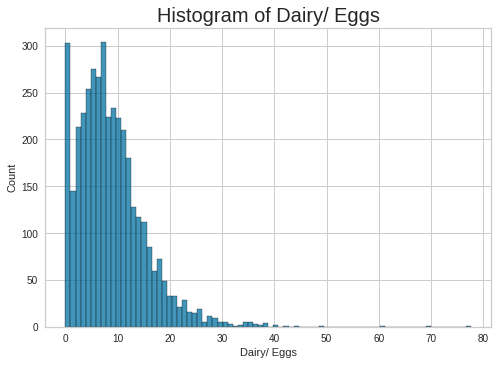

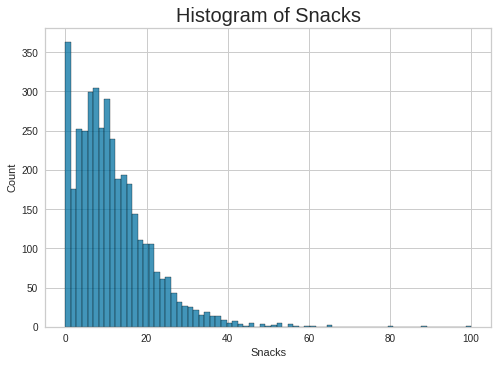

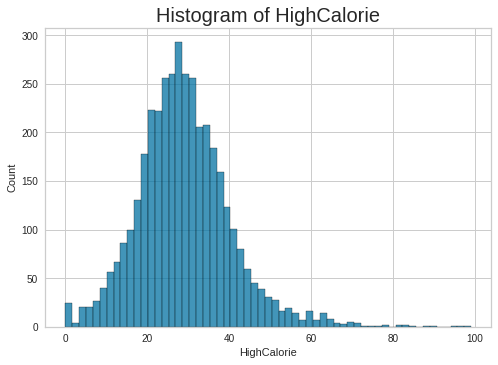

In [48]:
# plot to see distribution of continuous variables in pctgofspending_df

for i in range(pctgofspending_df.iloc[:,1:].shape[1]):
  var = pctgofspending_df.iloc[:,1:].columns[i]
  ax = sns.histplot(pctgofspending_df[var]);
  ax.set_title("Histogram of "+ var, fontsize=20);
  plt.show()


## Clustering by Shopping Habits

In [49]:
#Plot boxplots of each feature after attaching cluster label in each row
#Input: df with labels, Output: plt graphs
def plot_boxplots(data_with_label):
  plt.figure(figsize=(30,30))
  sns.set(font_scale = 2)
  for i in range(len(data_with_label.columns)-1):
    plt.subplot(3,3,i+1)
    sns.boxplot(y=data_with_label.columns[i], x='Clusters', data=data_with_label, palette="colorblind") 

#Plot the silhouettes
#Input: df, Output: plt graphs
def plot_silhouettes(data,num_clusters):
  dataarray = data.to_numpy()
  model = KMeans(num_clusters,random_state=42)
  plt.figure(figsize=(10, 7)) 
  sns.set(font_scale = 1)
  silhouette_visualizer(model, dataarray, colors='yellowbrick')
  score = silhouette_score(dataarray, model.labels_,metric = 'euclidean')
  print("For n_clusters = {0} The average silhouette_score is: {1} ".format(num_clusters,score))

In [50]:
finaldf.head()

Alcohol  Beverages  ...            #HH  Income
0      1.5       12.2  ...  1-3 Member HH     Low
1      1.8       14.7  ...  1-3 Member HH     Low
2      0.9       31.6  ...  4-5 Member HH     Low
3      0.0       24.7  ...  1-3 Member HH     Low
4      0.8       35.0  ...  1-3 Member HH     Low

[5 rows x 14 columns]

In [51]:
num_foodgroups = 6
shopping_df = finaldf.iloc[:, :num_foodgroups+1]

In [52]:
shopping_df.head()

Alcohol  Beverages  Carbohydrates  ...  Dairy/ Eggs  Snacks  HighCalorie
0      1.5       12.2           28.5  ...          9.2     5.9         38.6
1      1.8       14.7           29.9  ...          2.2     4.9         39.6
2      0.9       31.6           28.0  ...         15.6     3.1         30.2
3      0.0       24.7           17.4  ...          9.0    10.4         23.9
4      0.8       35.0           10.2  ...          9.9     8.3         36.9

[5 rows x 7 columns]

In [53]:
dataarray = np.array(shopping_df)

In [54]:
wcss = []
max_k = 10 # NOTE: Try 10 and 20
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dataarray)
    wcss.append(kmeans.inertia_)

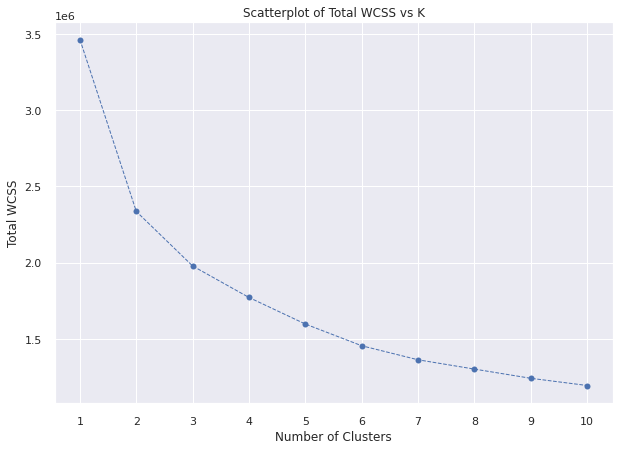

In [55]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [56]:
#To locate the elbow point of the curve using kneed package
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

3

In [57]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dataarray)
    score = silhouette_score(dataarray, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

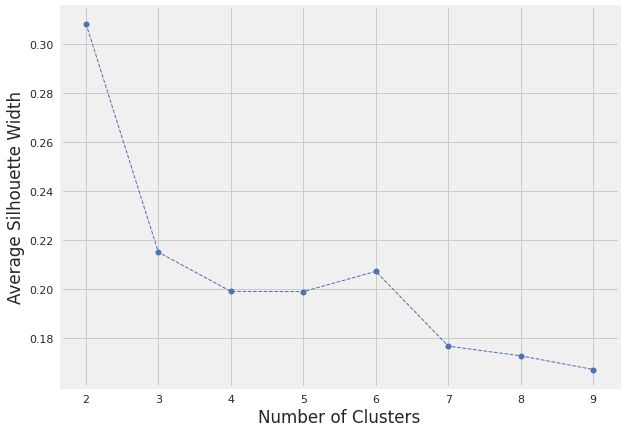

In [58]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

### kmeans with 3 clusters

In [59]:
kmeans3 = KMeans(init="random",n_clusters = 3 , n_init = 10, max_iter = 300, random_state = 42)
kmeans3.fit(dataarray)
clustergroups3 = kmeans3.labels_ #The cluster number for each row

In [60]:
Clustercenters3 = pd.DataFrame(kmeans3.cluster_centers_) #Dataframe of cluster centers
Clustercenters3.rename(columns={0: "Alcohol", 1: "Beverages", 2: "Carbohydrates", 3: "Cooking Essentials", 
                                4: "Dairy/ Eggs", 5: "Snacks", 6: "HighCalorie"},inplace=True)
Clustercenters3.index.name = "Clusters"

In [61]:
Clustercenters3

Alcohol  Beverages  ...     Snacks  HighCalorie
Clusters                       ...                        
0         1.095520  62.106400  ...   8.030400    24.587680
1         2.547410  31.962664  ...  15.100057    29.631076
2         1.582595  14.932399  ...   9.024641    30.347132

[3 rows x 7 columns]

In [62]:
#Inertia actually calculates the sum of distances of all the points within a cluster from the
#centroid of that cluster, and sum it against all clusters.

print(kmeans3.inertia_)
print('%.1E' % Decimal(kmeans3.inertia_))

1977260.6676333563
2.0E+06


In [63]:
model3 = shopping_df.copy()
model3['Clusters'] = list(kmeans3.labels_)
model3.groupby('Clusters').mean() #Quick summary of the means of each cluster, for each feature

Alcohol  Beverages  ...     Snacks  HighCalorie
Clusters                       ...                        
0         1.093770  62.080511  ...   8.033706    24.576038
1         2.544034  31.931364  ...  15.097557    29.642557
2         1.585621  14.914771  ...   9.014902    30.343856

[3 rows x 7 columns]

In [64]:
model3['Clusters'].value_counts()

1    1760
2    1530
0     626
Name: Clusters, dtype: int64

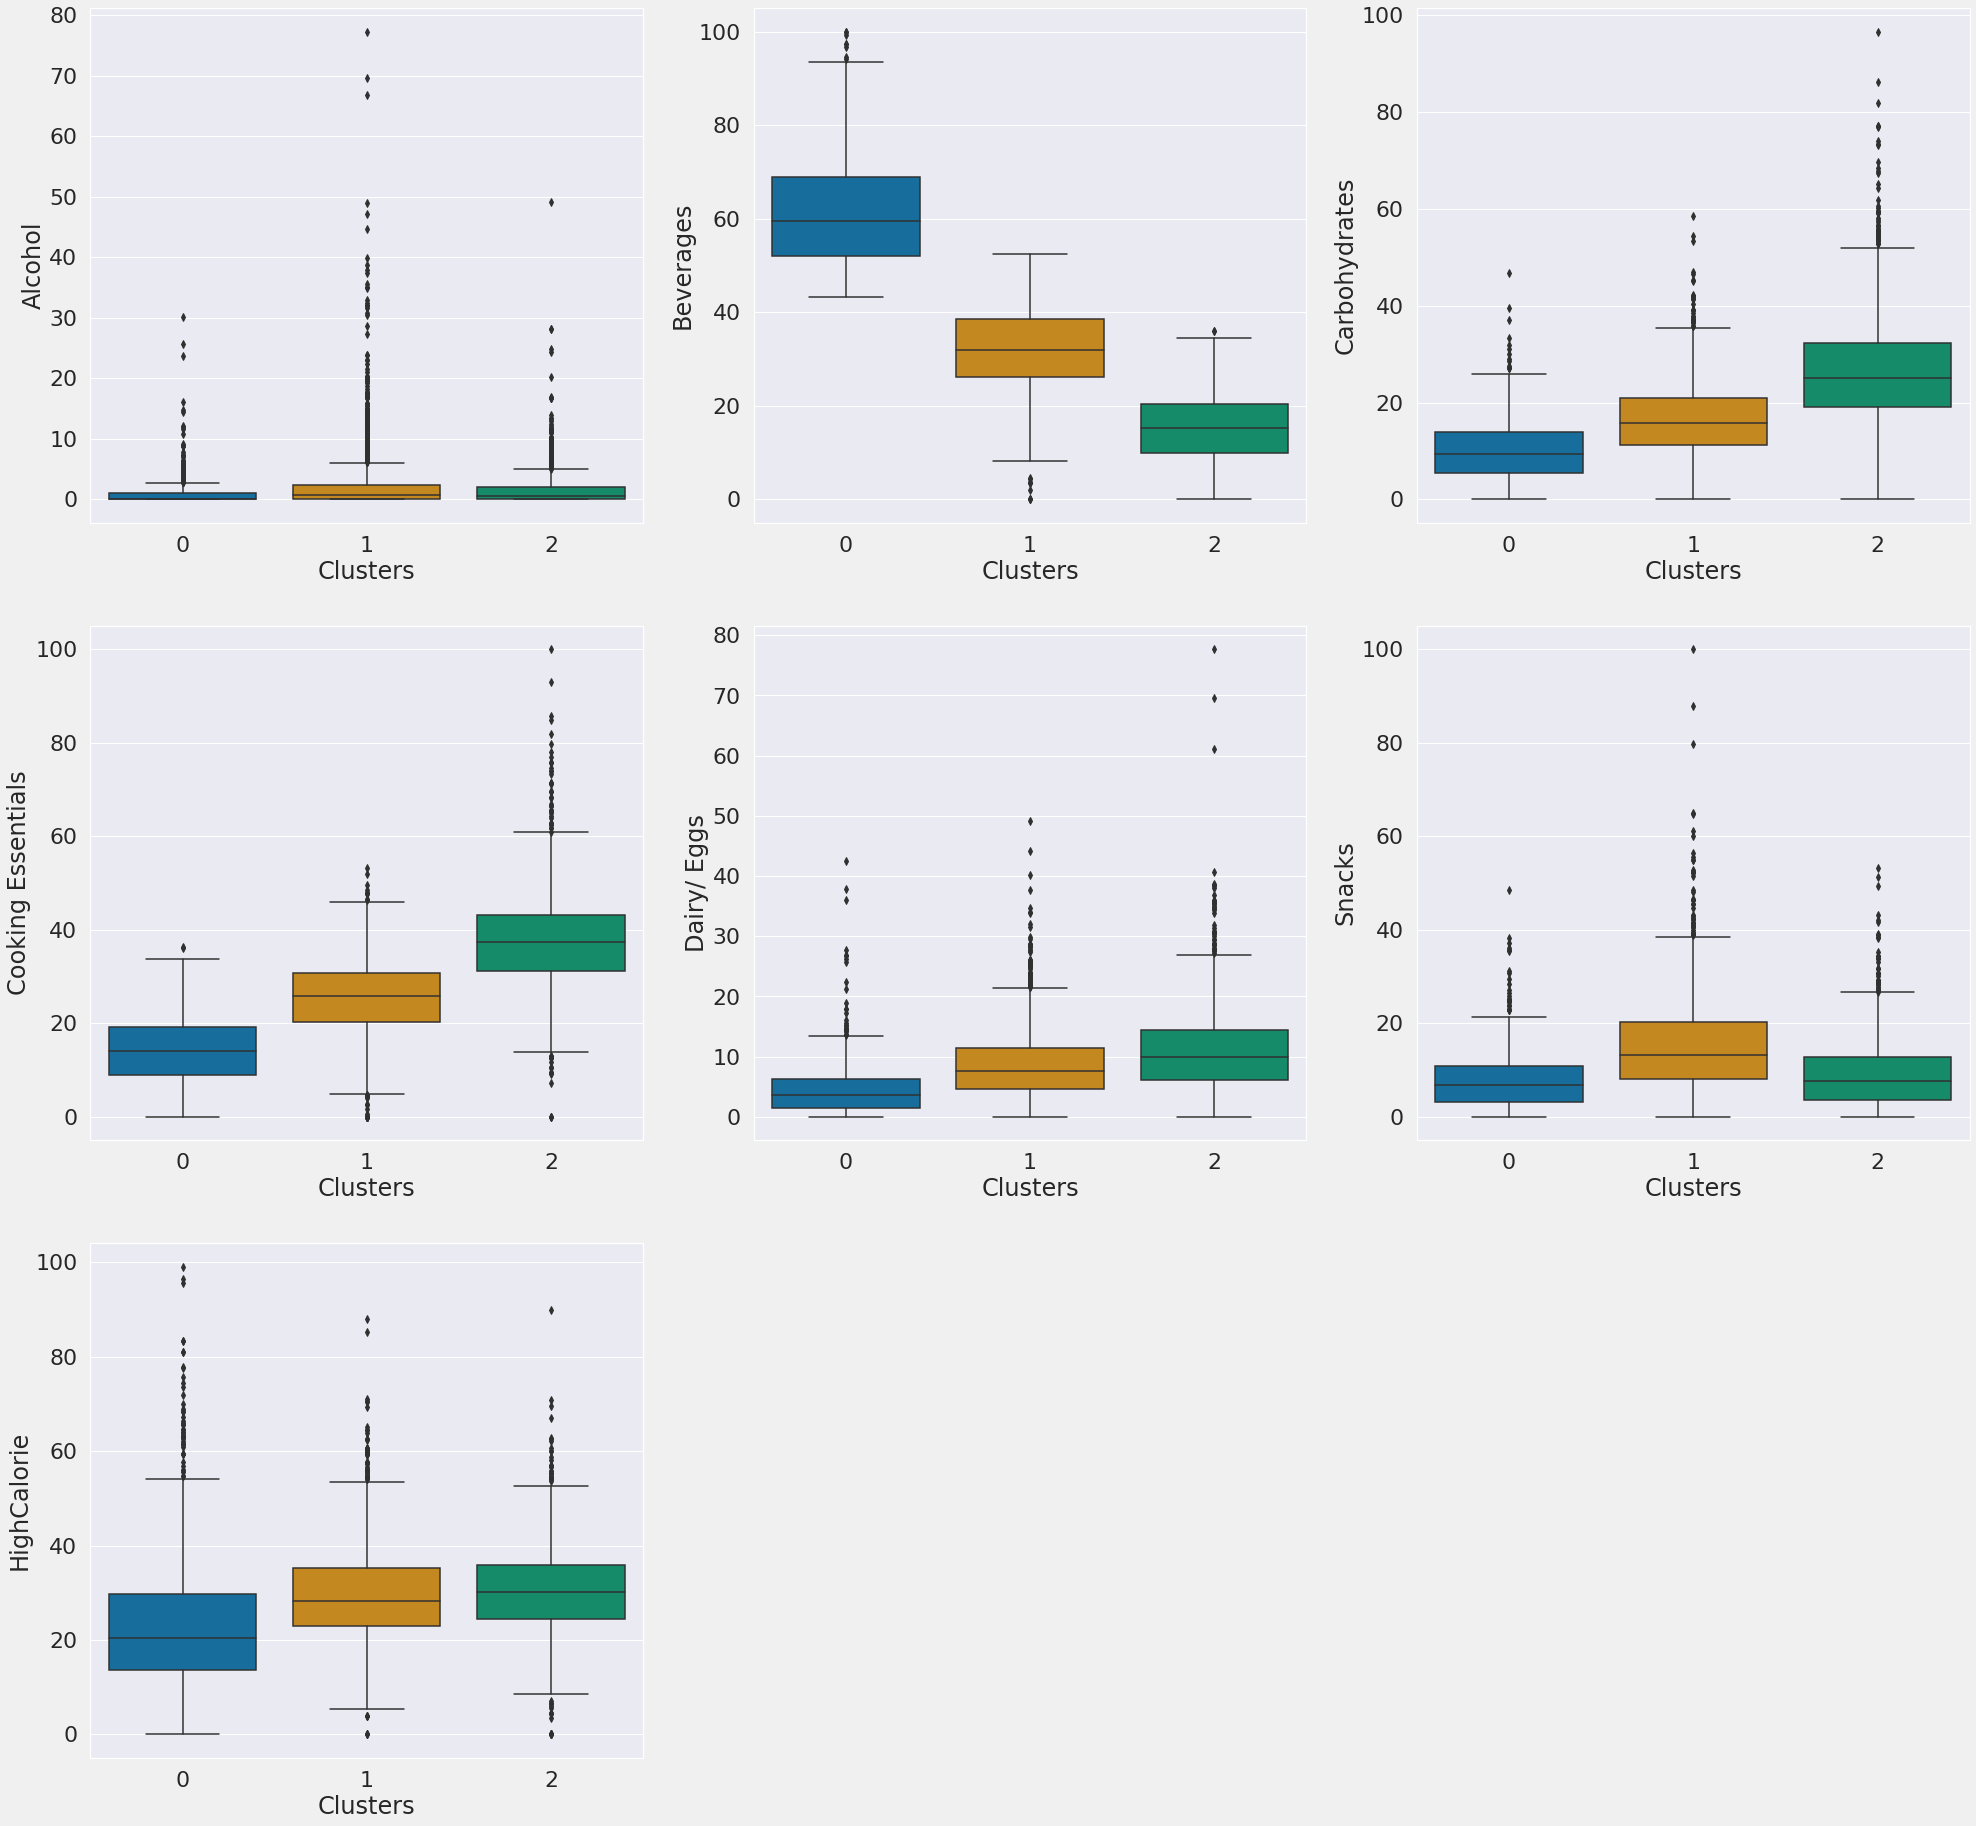

In [65]:
plot_boxplots(model3)

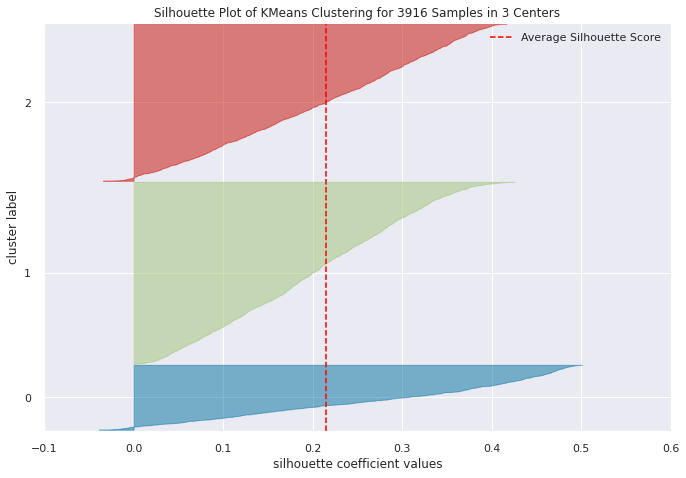

For n_clusters = 3 The average silhouette_score is: 0.2149082714137114 


In [66]:
plot_silhouettes(shopping_df,3)

### kmeans with 5 clusters

In [67]:
kmeans5 = KMeans(init="random",n_clusters = 5 , n_init = 10, max_iter = 300, random_state = 42)
kmeans5.fit(dataarray)
clustergroups5 = kmeans5.labels_ #The cluster number for each row

In [68]:
Clustercenters5 = pd.DataFrame(kmeans5.cluster_centers_) #Dataframe of cluster centers
Clustercenters5.rename(columns={0: "Alcohol", 1: "Beverages", 2: "Carbohydrates", 3: "Cooking Essentials", 
                                4: "Dairy/ Eggs", 5: "Snacks", 6: "HighCalorie"},inplace=True)
Clustercenters5.index.name = "Clusters"

In [69]:
Clustercenters5

Alcohol  Beverages  ...     Snacks  HighCalorie
Clusters                       ...                        
0         2.548415  38.384747  ...   9.959554    26.652871
1         0.952814  66.583117  ...   7.685065    25.163420
2         1.770332  17.748815  ...   8.798957    31.945308
3         1.368617  13.933688  ...   7.004078    26.216844
4         2.297006  23.564671  ...  25.429790    34.077246

[5 rows x 7 columns]

In [70]:
print(kmeans5.inertia_)
print('%.1E' % Decimal(kmeans5.inertia_))

1596681.0256668823
1.6E+06


In [71]:
model5 = shopping_df.copy()
model5['Clusters'] = list(kmeans5.labels_)
model5.groupby('Clusters').mean() #Quick summary of the means of each cluster, for each feature

Alcohol  Beverages  ...     Snacks  HighCalorie
Clusters                       ...                        
0         2.550599  38.374401  ...   9.962586    26.654880
1         0.952814  66.583117  ...   7.685065    25.163420
2         1.770332  17.748815  ...   8.798957    31.945308
3         1.368617  13.933688  ...   7.004078    26.216844
4         2.292804  23.560570  ...  25.447676    34.084858

[5 rows x 7 columns]

In [72]:
model5['Clusters'].value_counts()

0    1168
2    1055
4     667
3     564
1     462
Name: Clusters, dtype: int64

We could describe the 5 clusters in the following way:
- 0: Highest alcohol consumption
- 1: People who seldom cook at home but consume a lot of beverages
- 2: Large spenders on cooking essentials
- 3: People with a high carb diet
- 4: People who snack a lot while drinking alcohol



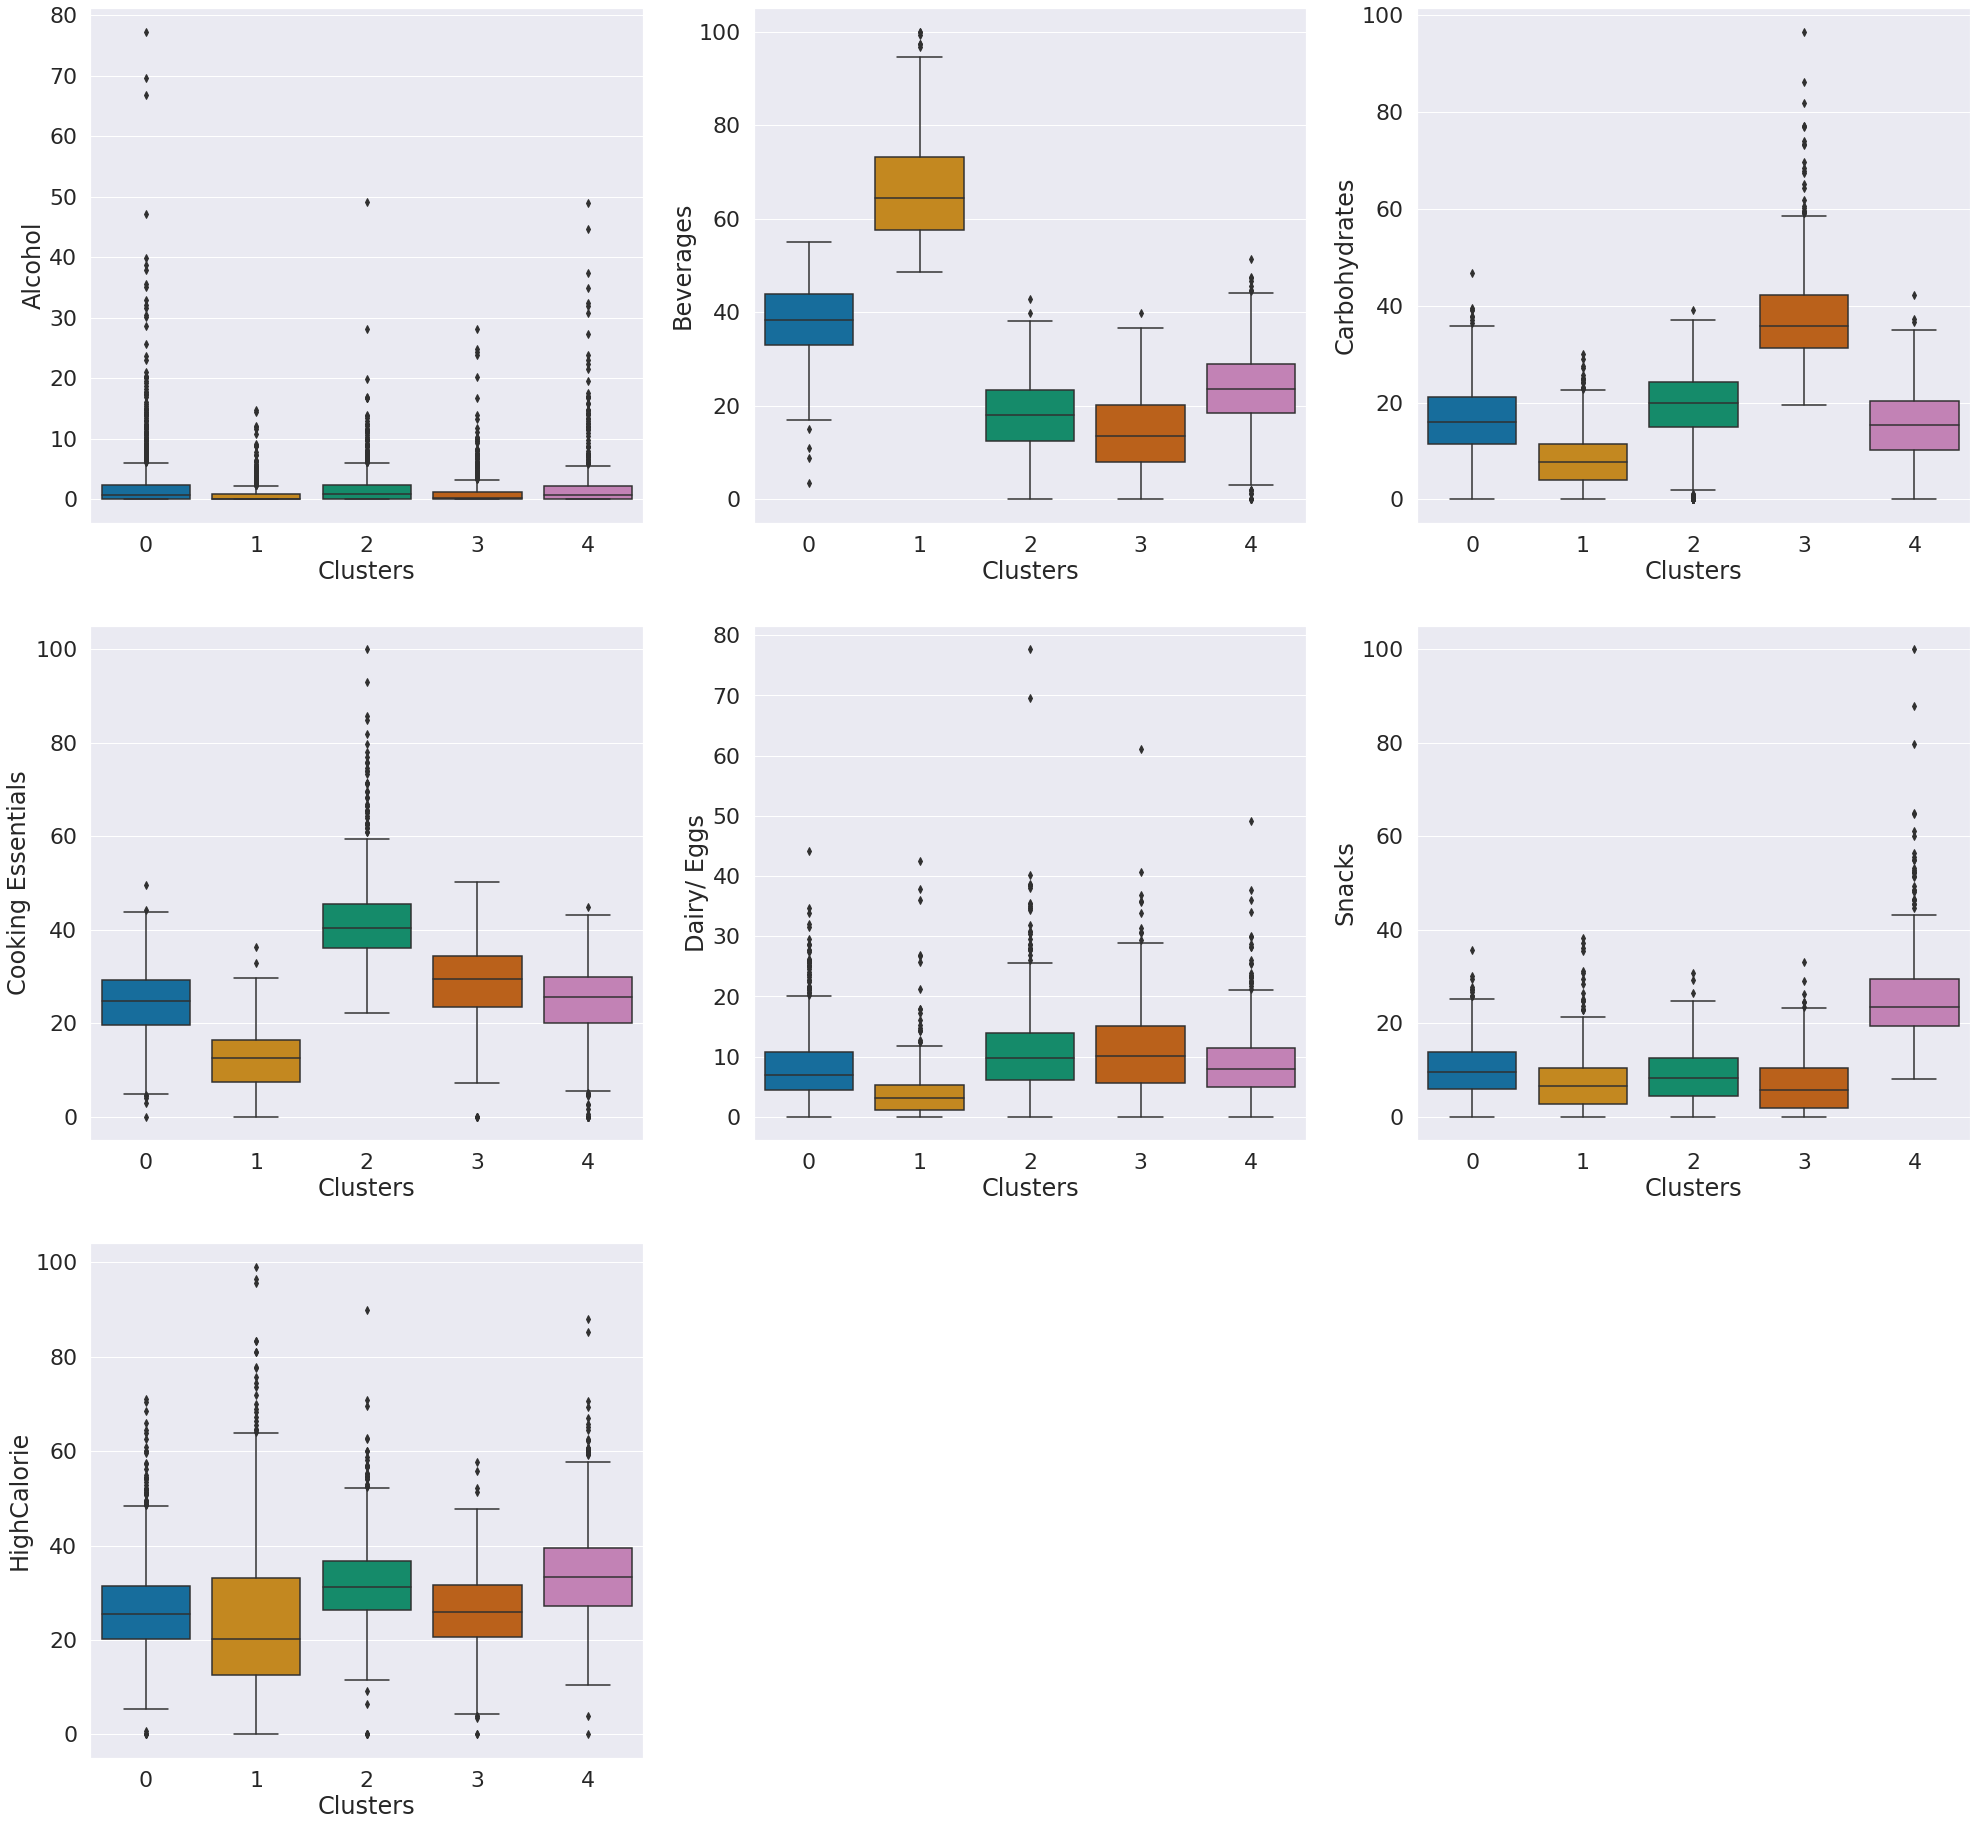

In [73]:
plot_boxplots(model5)

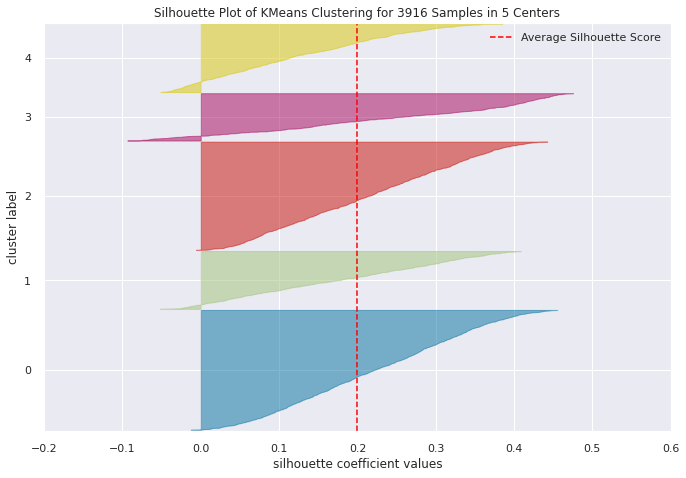

For n_clusters = 5 The average silhouette_score is: 0.19894058238736273 


In [74]:
plot_silhouettes(shopping_df,5)

### kmeans with 6 clusters

In [75]:
kmeans6 = KMeans(init="random",n_clusters = 6 , n_init = 10, max_iter = 300, random_state = 42)
kmeans6.fit(dataarray)
clustergroups6 = kmeans6.labels_ #The cluster number for each row

In [76]:
Clustercenters6 = pd.DataFrame(kmeans6.cluster_centers_) #Dataframe of cluster centers
Clustercenters6.rename(columns={0: "Alcohol", 1: "Beverages", 2: "Carbohydrates", 3: "Cooking Essentials", 
                                4: "Dairy/ Eggs", 5: "Snacks", 6: "HighCalorie"},inplace=True)
Clustercenters6.index.name = "Clusters"

In [77]:
Clustercenters6

Alcohol  Beverages  ...     Snacks  HighCalorie
Clusters                       ...                        
0         1.377431  13.592014  ...   7.154688    26.328472
1         1.771930  18.057115  ...   8.594152    32.229337
2         2.719109  38.033024  ...   9.948145    24.474954
3         0.985546  67.814159  ...   7.051622    16.429204
4         0.752511  54.491324  ...  10.883105    51.133333
5         2.281268  23.013864  ...  25.010177    33.329499

[6 rows x 7 columns]

In [78]:
print(kmeans6.inertia_)
print('%.1E' % Decimal(kmeans6.inertia_))

1454368.302493477
1.5E+06


In [79]:
model6 = shopping_df.copy()
model6['Clusters'] = list(kmeans6.labels_)
model6.groupby('Clusters').mean() #Quick summary of the means of each cluster, for each feature

Alcohol  Beverages  ...     Snacks  HighCalorie
Clusters                       ...                        
0         1.377431  13.592014  ...   7.154688    26.328472
1         1.769650  18.063716  ...   8.611965    32.226654
2         2.721634  38.019963  ...   9.950604    24.483194
3         0.982647  67.767941  ...   7.052353    16.426765
4         0.752511  54.491324  ...  10.883105    51.133333
5         2.286243  23.018491  ...  25.031657    33.336834

[6 rows x 7 columns]

In [80]:
model6['Clusters'].value_counts()

2    1077
1    1028
5     676
0     576
3     340
4     219
Name: Clusters, dtype: int64

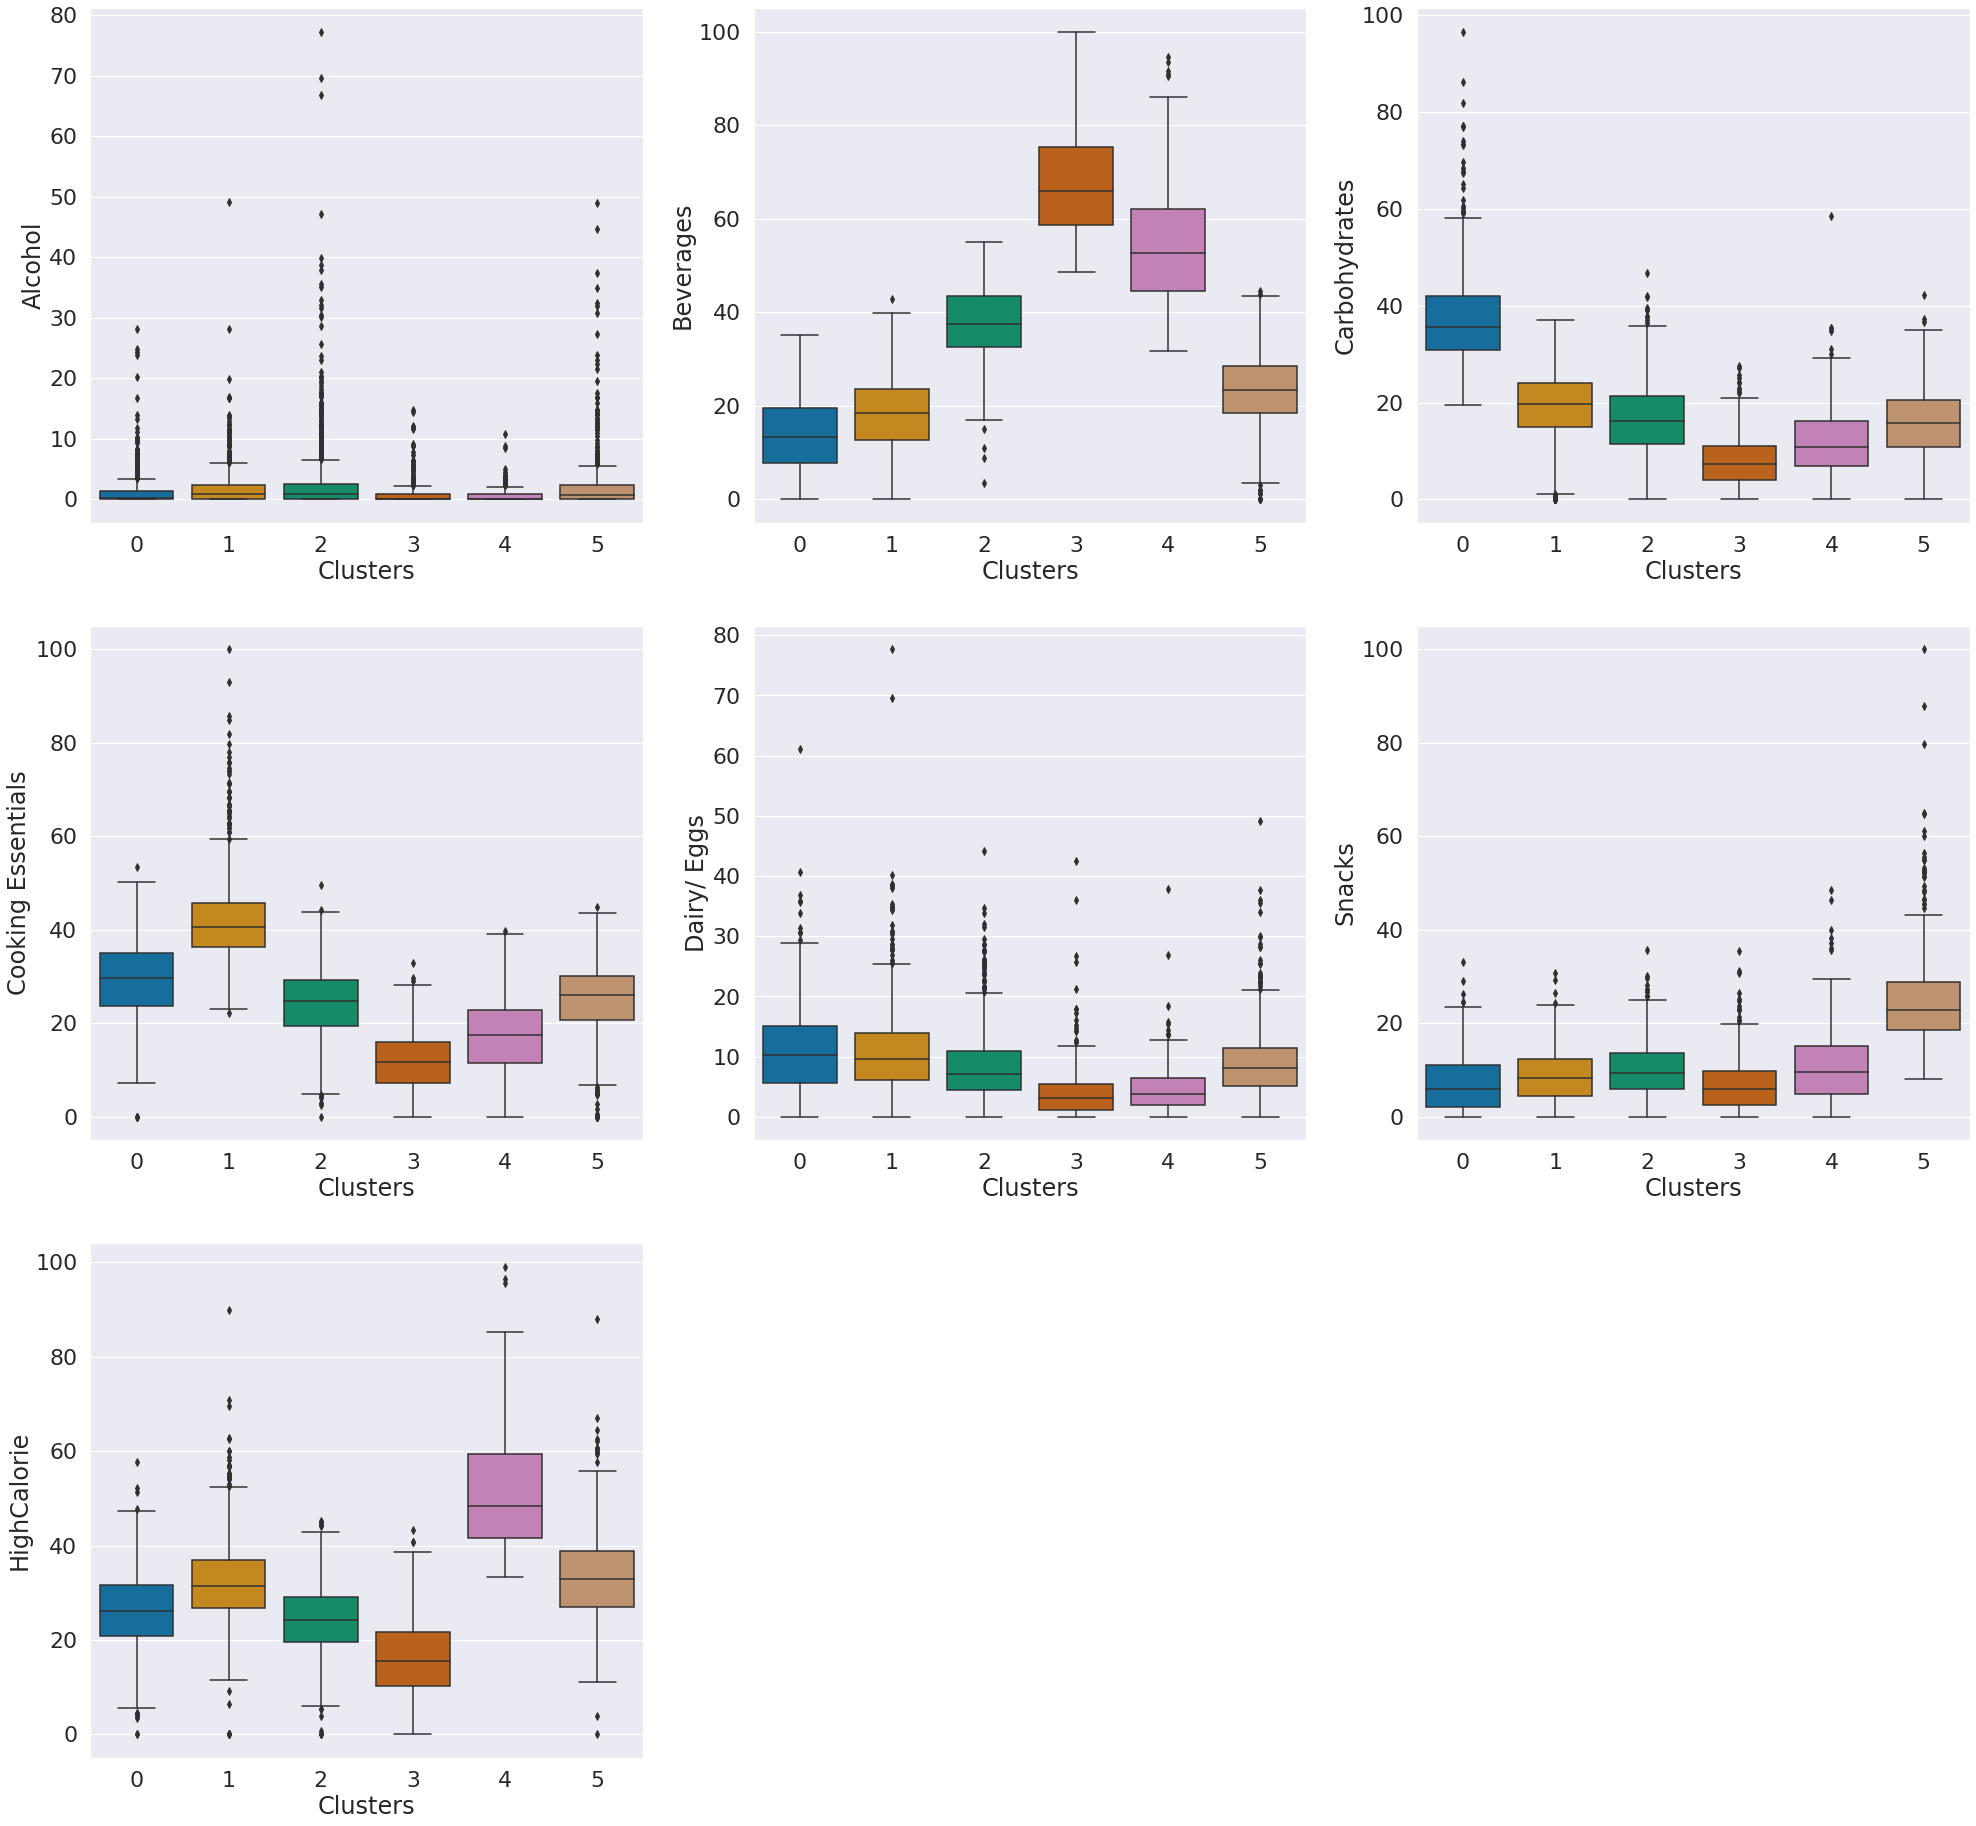

In [81]:
plot_boxplots(model6)

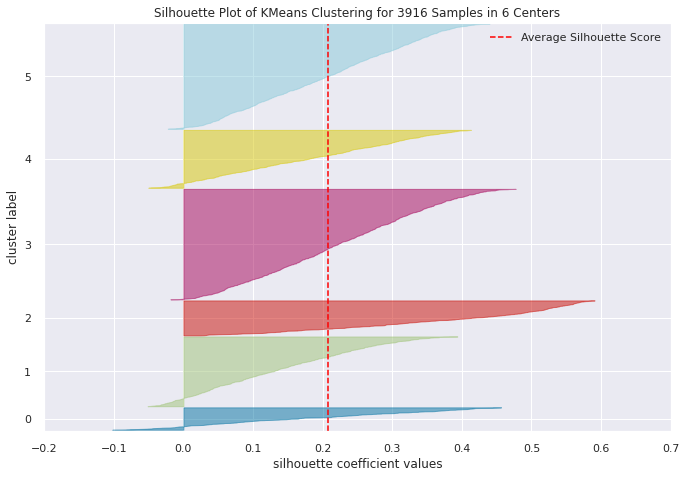

For n_clusters = 6 The average silhouette_score is: 0.20719331787549516 


In [82]:
plot_silhouettes(shopping_df,6)

## Analysing Demographics of Each Cluster

We will go with 5 clusters as it splits the panelists into reasonably sized groups with distinct characteristics.

In [83]:
finaldf['Clusters'] = list(kmeans5.labels_)
finaldf.head()

Alcohol  Beverages  Carbohydrates  ...            #HH  Income  Clusters
0      1.5       12.2           28.5  ...  1-3 Member HH     Low         2
1      1.8       14.7           29.9  ...  1-3 Member HH     Low         2
2      0.9       31.6           28.0  ...  4-5 Member HH     Low         0
3      0.0       24.7           17.4  ...  1-3 Member HH     Low         2
4      0.8       35.0           10.2  ...  1-3 Member HH     Low         0

[5 rows x 15 columns]

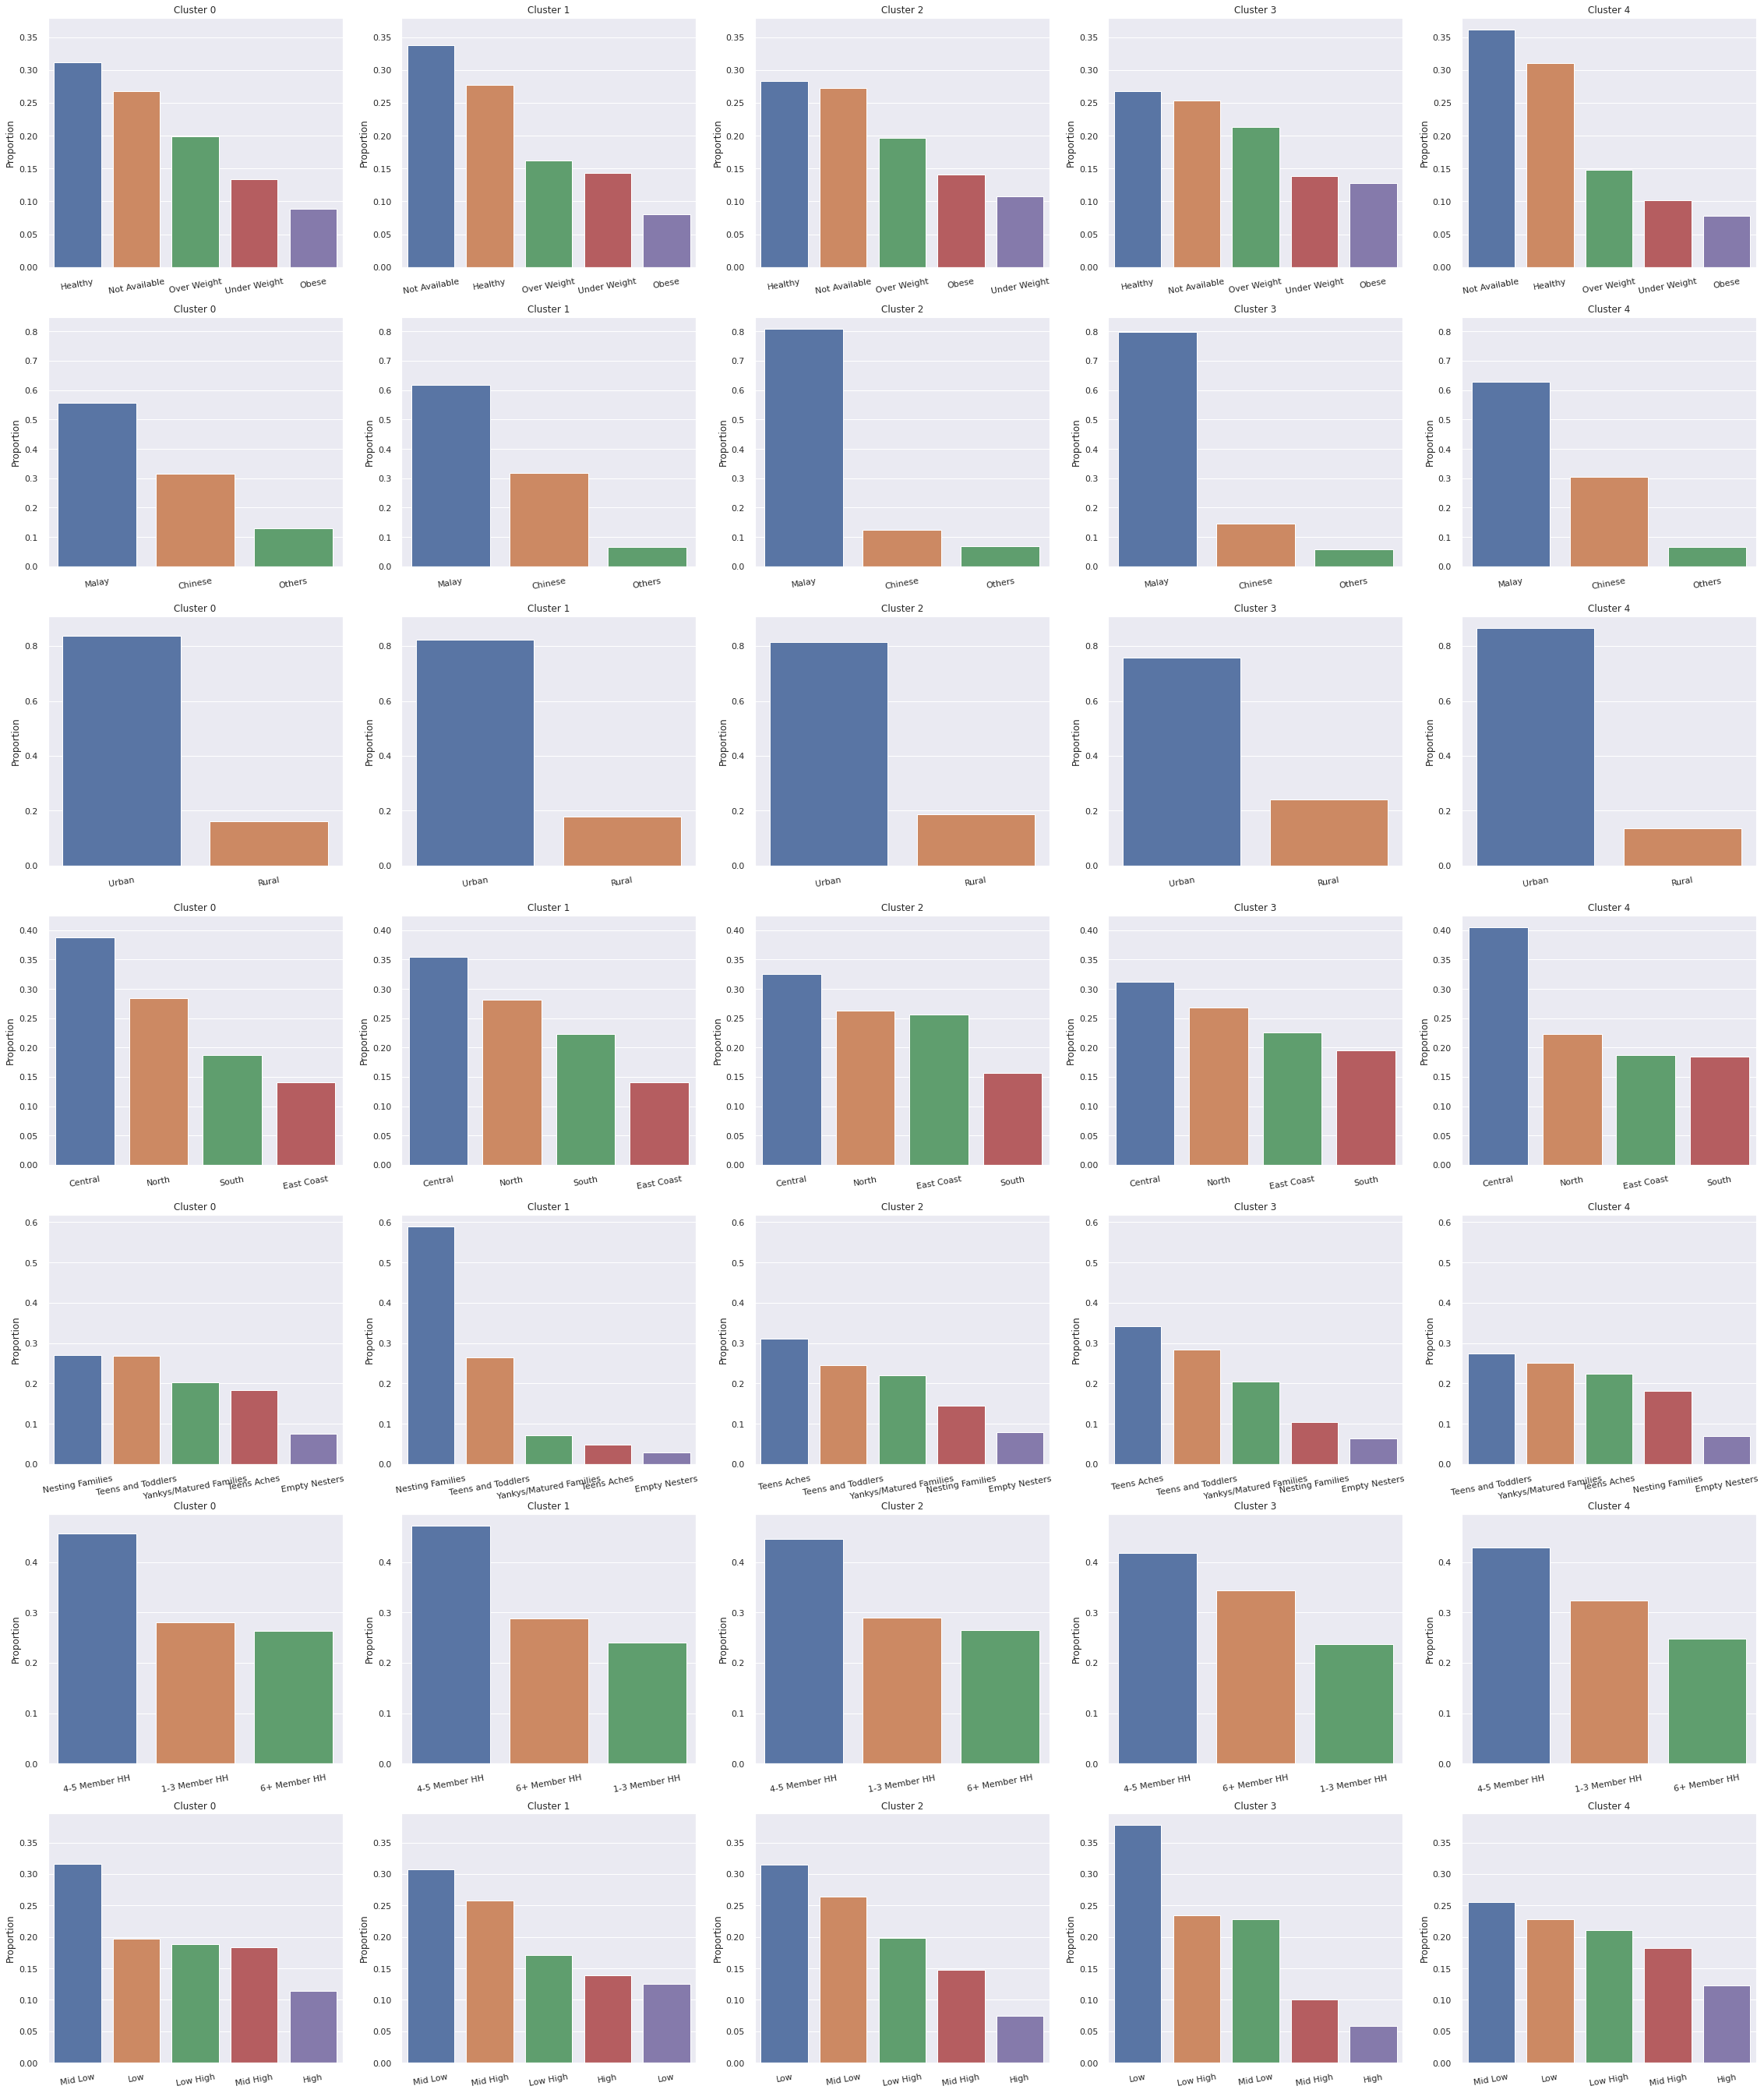

In [84]:
demogs_by_cluster = finaldf.iloc[:, 7:]

sns.set(font_scale=1)
fig, axs = plt.subplots(7, 5, figsize=(35,45), sharey='row')

for i in range(5):
  X = demogs_by_cluster[demogs_by_cluster['Clusters']==i]
  grpsize = len(X)
  
  for j in range(7):
    col = X.columns[j]
    df = X[col].value_counts().rename_axis('unique_values').reset_index(name='counts')
    df['counts'] = df['counts']/grpsize
    chart=sns.barplot(x = 'unique_values', y = 'counts', data=df, ax=axs[j, i])
    chart.set(xlabel = "", ylabel = "Proportion")
    chart.set_xticklabels(chart.get_xticklabels(), rotation=10)
    axs[j, i].yaxis.set_tick_params(labelleft=True)
    axs[j, i].set_title("Cluster "+ str(i))


General demographics of the 5 clusters:
- 0: Highest alcohol consumption - has the highest proportion of healthy BMI (~30%), majority young families with 4-5 members, majority mid-low income level
- 1: People who seldom cook at home but consume a lot of beverages - overwhelming majority are nesting families, mid-low/mid-high income
- 2: Large spenders on cooking essentials - low proportion of underweight, overwhelming majority are of Malay ethnicity, low/mid-low income
- 3: People with a high carb diet - relatively even distribution of BMI, overwhelming majority of Malay ethnicity, teen aches/teens and toddlers lifestage, low/low-high income
- 4: People who snack a lot while drinking alcohol - ~40% living in central area, matured families/teens and toddlers lifestage, most even spread of income
